In [119]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torch.optim as optim
# 사전 학습된 모델을 이용하고자 할 때 사용하는 라이브러리
import torchvision.models as models
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time
# 함수에 넘겨주는 인수 값에 따라서 학습률 감소나 조기 종료를 도와주는 라이브러리
import argparse
from tqdm import tqdm
import numpy as np
import sys

# 출력 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 하는 스타일
matplotlib.style.use('ggplot')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [120]:
# 데이터셋 전처리
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.486, 0.496],
                         std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.486, 0.496],
                         std=[0.229, 0.224, 0.225]),
])

In [121]:
train_dataset = datasets.ImageFolder(
    root=r'../data/archive/train',
    transform=train_transform,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
print(train_dataloader.batch_size)
val_dataset = datasets.ImageFolder(
    root=r'../data/archive/test',
    transform=val_transform,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=True,
)

32


In [122]:
# 모델 생성
def resnet50(pretrained=True, requires_grad=False):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # 파라미터를 고정하여 backward() 중에 기울기가 계산되지 않도록 함
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # 파라미터 값이 backward() 중에 기울기 계산에 반영됩니다.
    else:
        for param in model.parameters():
            param.requires_grad == True
    
    # 마지막 분류를 위한 계층은 학습을 진행
    model.fc = nn.Linear(2048, 2)
    return model

In [123]:
# 학습률 감소
class LRScheduler():
    
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        # 모델 성능에 대한 개선이 없을 때 모델의 개선을 유도하는 콜백 함수
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            # 모델의 오차가 내려가지 않을 때
            mode = 'min',
            patience = self.patience,
            # 학습률 감소 정도
            factor = self.factor,
            min_lr = self.min_lr,
            verbose = True,
        )
    
    def __call__(self, val_loss):
        # 이전 오차와 비교했을 때 차이가 없다면 학습률을 업데이트
        self.lr_scheduler.step(val_loss)

In [124]:
# 조기 종료
class EarlyStopping():

    def __init__(self, patience=5, verbose=False, delta=0, path='../data/checkpoint.pt'):
        # 오차 개선이 없는 에포크를 몇 번 기다려줄지
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        # 검증 데이터셋에 대한 오차 최적화 값(오차가 가장 낮은 값)
        self.best_score = None
        # 조기 종료를 의미하며 초깃값은 False로 설정
        self.early_stop = False
        # np.Inf(infinity)는 넘파이에서 무한대를 표현
        self.val_loss_min = np.Inf
        # 개선이 없다고 생각하는 최소 변화량
        self.dalta = delta
        # 모델이 저장된 경로
        self.path = path

    # 에포크만큼 학습이 반복되면서 best_loss가 갱신되고, best_loss에 진전이 없으면 조기 종료가 하고 모델을 저장
    def call(self, val_loss, model):
        score = -val_loss
        # best_score 값이 존재하지 않으면 실행
        if self.best_score is None:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    # 검증 데이터셋에 대한 오차가 감소하면 모델을 저장
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        # 저장된 경로에 모델 저장
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [125]:
# 인수 값 지정
# pip install ipywidgets

# Jupyter Notebook의 추가 인수를 제거
sys.argv = sys.argv[:1]

# 인수 값을 받을 수 있는 인스턴스 생성
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
# 조기 종료에 대한 인수
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
# 입력 받은 인수 값이 실제로 args 변수에 저장
args = vars(parser.parse_args())

In [126]:
# 사전 훈련된 모델의 파라미터 확인
print(f'Computation device: {device}\n')
model = models.resnet50().to(device)
# 총 파라미터 수
total_params = sum(p.numel() for p in model.parameters()) 
print(f'{total_params:,} total parameters.')
# 학습 가능한 파라미터 수
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters')

Computation device: cuda:0



25,557,032 total parameters.
25,557,032 training parameters


In [127]:
# 옵티마이저와 손실 함수 지정
Ir = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=Ir)
criterion = nn.CrossEntropyLoss()

In [128]:
# 오차, 정확도 및 모델 이름에 대한 문자열

# 오차 출력에 대한 문자열
loss_plot_name = 'loss'
# 정확도 출력에 대한 문자열
acc_plot_name = 'accuracy'
# 모델을 저장하기 위한 문자열
model_name = 'model'

In [129]:
# 오차, 정확도 및 모델의 이름에 대한 문자열
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    # 학습률 감소를 적용했을 때 오차에 대한 문자열
    loss_plot_name = 'lrs_loss'
    # 학습률 감소를 적용했을 때의 정확도에 대한 문자열
    acc_plot_name = 'lrs_accuracy'
    # 학습률 감소를 적용했을 때 모델에 대한 문자열
    model_name = 'lrs_model'
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss'
    acc_plot_name = 'es_accuracy'
    model_name = 'es_model'

In [130]:
# 모델 학습 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter, total = 0, 0
    # 훈련 과정을 시각적으로 표현
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset) / train_dataloader.batch_size))

    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, pred = torch.max(outputs.data, 1)
        train_running_correct += (pred == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100 * train_running_correct / total
    return train_loss, train_accuracy


In [131]:
# 모델 성능 검증 함수
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0.0
    counter, total = 0, 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset) / test_dataloader.batch_size))

    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100 * val_running_correct / total
        return val_loss,  val_accuracy

In [132]:
# 모델 학습
# 훈련 데이터셋을 이용한 모델 학습 결과(오차, 정확도)를 저장하기 위한 변수(리스트 형태를 갖습니다.)
train_loss, train_accuracy = [], []
# 검증데이터셋을 이용한 모델 성능 결과(오차, 정확도)를 저장하기 위한 변수(리스트 형태를 갖습니다.)
val_loss, val_accuracy = [], []

start = time.time()
for epoch in range(epochs):
    print(f'Epoch {epoch+1} of {epochs}')
    train_epoch_loss, train_epoch_accuracy = training(model, train_dataloader, train_dataset, optimizer, criterion)
    val_epoch_loss, val_epoch_accuracy = validate(model, val_dataloader, val_dataset, criterion)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break

    print(f'Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}')
    print(f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f'Training time: {(end - start) / 60:.3f} minutes')

Epoch 1 of 100
Training


16it [00:05,  3.06it/s]                        


Validating


16it [00:11,  1.43it/s]                        


Train Loss: 1.6666, Train Acc: 48.80
Val Loss: 0.7850 Val Acc: 53.60
Epoch 2 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.6985, Train Acc: 58.03
Val Loss: 0.9171 Val Acc: 51.20
Epoch 3 of 100
Training


16it [00:17,  1.09s/it]                        


Validating


16it [00:03,  4.57it/s]                        


Train Loss: 0.6994, Train Acc: 57.63
Val Loss: 0.7127 Val Acc: 51.60
Epoch 4 of 100
Training


16it [00:11,  1.36it/s]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.6301, Train Acc: 66.47
Val Loss: 0.8877 Val Acc: 51.20
Epoch 5 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.83it/s]                        


Train Loss: 0.6458, Train Acc: 65.86
Val Loss: 1.0707 Val Acc: 56.80
Epoch 6 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.82it/s]                        


Train Loss: 0.6446, Train Acc: 69.08
Val Loss: 0.7343 Val Acc: 58.40
Epoch 7 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.5947, Train Acc: 71.49
Val Loss: 0.8800 Val Acc: 53.20
Epoch 8 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.5882, Train Acc: 69.28
Val Loss: 0.9655 Val Acc: 55.20
Epoch 9 of 100
Training


16it [00:20,  1.26s/it]                        


Validating


16it [00:08,  1.83it/s]                        


Train Loss: 0.6240, Train Acc: 69.28
Val Loss: 1.0473 Val Acc: 56.20
Epoch 10 of 100
Training


16it [00:20,  1.26s/it]                        


Validating


16it [00:08,  1.83it/s]                        


Train Loss: 0.6598, Train Acc: 63.86
Val Loss: 0.7295 Val Acc: 57.20
Epoch 11 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.5667, Train Acc: 70.28
Val Loss: 0.8860 Val Acc: 56.20
Epoch 12 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.83it/s]                        


Train Loss: 0.5486, Train Acc: 73.90
Val Loss: 0.7732 Val Acc: 63.40
Epoch 13 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.83it/s]                        


Train Loss: 0.5323, Train Acc: 73.90
Val Loss: 0.7279 Val Acc: 60.20
Epoch 14 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.5042, Train Acc: 76.10
Val Loss: 0.8684 Val Acc: 56.20
Epoch 15 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.5161, Train Acc: 75.70
Val Loss: 1.3641 Val Acc: 56.00
Epoch 16 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.6399, Train Acc: 67.27
Val Loss: 0.6983 Val Acc: 59.80
Epoch 17 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.83it/s]                        


Train Loss: 0.5491, Train Acc: 76.51
Val Loss: 0.7792 Val Acc: 52.80
Epoch 18 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.5422, Train Acc: 77.91
Val Loss: 2.4909 Val Acc: 49.60
Epoch 19 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.82it/s]                        


Train Loss: 0.5038, Train Acc: 77.91
Val Loss: 0.8309 Val Acc: 56.00
Epoch 20 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.4322, Train Acc: 80.32
Val Loss: 0.8752 Val Acc: 61.00
Epoch 21 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.5478, Train Acc: 74.30
Val Loss: 0.8212 Val Acc: 53.40
Epoch 22 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.4754, Train Acc: 79.72
Val Loss: 1.1472 Val Acc: 56.20
Epoch 23 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.4235, Train Acc: 82.53
Val Loss: 0.9019 Val Acc: 59.80
Epoch 24 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.3224, Train Acc: 86.14
Val Loss: 1.4167 Val Acc: 51.00
Epoch 25 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.5149, Train Acc: 78.71
Val Loss: 1.0097 Val Acc: 56.60
Epoch 26 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.4075, Train Acc: 79.92
Val Loss: 0.9225 Val Acc: 58.40
Epoch 27 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.3741, Train Acc: 85.14
Val Loss: 1.0202 Val Acc: 59.80
Epoch 28 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.6083, Train Acc: 75.50
Val Loss: 1.8768 Val Acc: 60.60
Epoch 29 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.4849, Train Acc: 79.12
Val Loss: 1.2155 Val Acc: 59.40
Epoch 30 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.3939, Train Acc: 84.74
Val Loss: 1.3982 Val Acc: 54.40
Epoch 31 of 100
Training


16it [00:19,  1.24s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.3645, Train Acc: 83.33
Val Loss: 0.9596 Val Acc: 63.20
Epoch 32 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.2925, Train Acc: 87.95
Val Loss: 1.2118 Val Acc: 55.80
Epoch 33 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.2364, Train Acc: 90.16
Val Loss: 1.1799 Val Acc: 62.80
Epoch 34 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.2671, Train Acc: 90.16
Val Loss: 1.5271 Val Acc: 56.60
Epoch 35 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.91it/s]                        


Train Loss: 0.2889, Train Acc: 87.55
Val Loss: 1.1797 Val Acc: 59.40
Epoch 36 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.2847, Train Acc: 88.15
Val Loss: 1.0536 Val Acc: 59.80
Epoch 37 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.90it/s]                        


Train Loss: 0.2777, Train Acc: 87.35
Val Loss: 1.0358 Val Acc: 58.40
Epoch 38 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.2685, Train Acc: 89.16
Val Loss: 1.0949 Val Acc: 60.00
Epoch 39 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.2190, Train Acc: 90.96
Val Loss: 1.4433 Val Acc: 58.00
Epoch 40 of 100
Training


16it [00:09,  1.61it/s]                        


Validating


16it [00:03,  4.31it/s]                        


Train Loss: 0.2256, Train Acc: 91.77
Val Loss: 1.3870 Val Acc: 57.60
Epoch 41 of 100
Training


16it [00:05,  3.02it/s]                        


Validating


16it [00:03,  4.79it/s]                        


Train Loss: 0.2008, Train Acc: 91.16
Val Loss: 1.2531 Val Acc: 60.00
Epoch 42 of 100
Training


16it [00:09,  1.63it/s]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.2178, Train Acc: 91.57
Val Loss: 1.2319 Val Acc: 58.60
Epoch 43 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.2727, Train Acc: 89.76
Val Loss: 1.1453 Val Acc: 61.00
Epoch 44 of 100
Training


16it [00:20,  1.26s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.2537, Train Acc: 89.56
Val Loss: 1.2600 Val Acc: 57.60
Epoch 45 of 100
Training


16it [00:20,  1.26s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.2305, Train Acc: 89.56
Val Loss: 1.2047 Val Acc: 58.00
Epoch 46 of 100
Training


16it [00:20,  1.26s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.2188, Train Acc: 91.97
Val Loss: 1.2579 Val Acc: 60.00
Epoch 47 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.2063, Train Acc: 90.96
Val Loss: 1.3252 Val Acc: 60.80
Epoch 48 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.85it/s]                        


Train Loss: 0.2078, Train Acc: 91.16
Val Loss: 1.3531 Val Acc: 58.20
Epoch 49 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.1425, Train Acc: 94.38
Val Loss: 1.3733 Val Acc: 56.20
Epoch 50 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.1482, Train Acc: 93.98
Val Loss: 1.4501 Val Acc: 57.40
Epoch 51 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.1435, Train Acc: 93.78
Val Loss: 1.5172 Val Acc: 58.20
Epoch 52 of 100
Training


16it [00:19,  1.25s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.1465, Train Acc: 94.38
Val Loss: 1.6074 Val Acc: 55.20
Epoch 53 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.91it/s]                        


Train Loss: 0.2311, Train Acc: 90.76
Val Loss: 1.7375 Val Acc: 60.40
Epoch 54 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.2740, Train Acc: 89.76
Val Loss: 1.1172 Val Acc: 58.40
Epoch 55 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.1898, Train Acc: 93.57
Val Loss: 1.1495 Val Acc: 60.40
Epoch 56 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.1745, Train Acc: 92.57
Val Loss: 1.3048 Val Acc: 57.80
Epoch 57 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.1037, Train Acc: 95.78
Val Loss: 1.5527 Val Acc: 58.20
Epoch 58 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.0953, Train Acc: 96.79
Val Loss: 1.5360 Val Acc: 61.40
Epoch 59 of 100
Training


16it [00:19,  1.21s/it]                        


Validating


16it [00:08,  1.90it/s]                        


Train Loss: 0.1757, Train Acc: 94.38
Val Loss: 1.8218 Val Acc: 57.00
Epoch 60 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.91it/s]                        


Train Loss: 0.1741, Train Acc: 93.57
Val Loss: 1.6113 Val Acc: 58.20
Epoch 61 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.1728, Train Acc: 93.98
Val Loss: 1.4924 Val Acc: 57.60
Epoch 62 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.1897, Train Acc: 93.37
Val Loss: 1.6632 Val Acc: 58.00
Epoch 63 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.94it/s]                        


Train Loss: 0.1485, Train Acc: 95.18
Val Loss: 1.8179 Val Acc: 58.00
Epoch 64 of 100
Training


16it [00:19,  1.21s/it]                        


Validating


16it [00:08,  1.91it/s]                        


Train Loss: 0.1181, Train Acc: 95.78
Val Loss: 1.9851 Val Acc: 57.20
Epoch 65 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.1706, Train Acc: 93.17
Val Loss: 1.5131 Val Acc: 58.40
Epoch 66 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.1297, Train Acc: 94.98
Val Loss: 1.4502 Val Acc: 61.00
Epoch 67 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.0865, Train Acc: 95.98
Val Loss: 1.6779 Val Acc: 56.60
Epoch 68 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.0963, Train Acc: 95.98
Val Loss: 1.7969 Val Acc: 59.60
Epoch 69 of 100
Training


16it [00:19,  1.21s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.1169, Train Acc: 95.18
Val Loss: 1.5257 Val Acc: 57.60
Epoch 70 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.0764, Train Acc: 97.19
Val Loss: 1.6542 Val Acc: 61.60
Epoch 71 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.0881, Train Acc: 96.59
Val Loss: 1.7330 Val Acc: 60.00
Epoch 72 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.93it/s]                        


Train Loss: 0.0749, Train Acc: 97.59
Val Loss: 1.8731 Val Acc: 56.60
Epoch 73 of 100
Training


16it [00:19,  1.20s/it]                        


Validating


16it [00:08,  1.92it/s]                        


Train Loss: 0.1031, Train Acc: 96.59
Val Loss: 2.0279 Val Acc: 58.00
Epoch 74 of 100
Training


16it [57:26, 215.39s/it]                         


Validating


16it [00:03,  4.13it/s]                        


Train Loss: 0.0791, Train Acc: 96.18
Val Loss: 2.0085 Val Acc: 55.60
Epoch 75 of 100
Training


16it [00:07,  2.18it/s]                        


Validating


16it [00:08,  1.84it/s]                        


Train Loss: 0.1073, Train Acc: 96.59
Val Loss: 1.8916 Val Acc: 58.80
Epoch 76 of 100
Training


16it [00:20,  1.28s/it]                        


Validating


16it [00:08,  1.86it/s]                        


Train Loss: 0.1061, Train Acc: 95.58
Val Loss: 1.9623 Val Acc: 55.80
Epoch 77 of 100
Training


16it [00:05,  2.86it/s]                        


Validating


16it [00:04,  3.62it/s]                        


Train Loss: 0.0809, Train Acc: 96.99
Val Loss: 1.9351 Val Acc: 57.80
Epoch 78 of 100
Training


16it [00:05,  3.00it/s]                        


Validating


16it [00:05,  2.90it/s]                        


Train Loss: 0.1722, Train Acc: 94.58
Val Loss: 1.7883 Val Acc: 58.80
Epoch 79 of 100
Training


16it [00:09,  1.72it/s]                        


Validating


16it [00:03,  4.52it/s]                        


Train Loss: 0.1483, Train Acc: 93.98
Val Loss: 1.5229 Val Acc: 59.00
Epoch 80 of 100
Training


16it [00:10,  1.50it/s]                        


Validating


16it [00:07,  2.08it/s]                        


Train Loss: 0.1500, Train Acc: 94.18
Val Loss: 1.6436 Val Acc: 56.20
Epoch 81 of 100
Training


16it [00:05,  3.06it/s]                        


Validating


16it [00:06,  2.43it/s]                        


Train Loss: 0.1500, Train Acc: 95.58
Val Loss: 1.4918 Val Acc: 60.20
Epoch 82 of 100
Training


16it [00:09,  1.68it/s]                        


Validating


16it [00:04,  3.85it/s]                        


Train Loss: 0.1108, Train Acc: 96.39
Val Loss: 1.4345 Val Acc: 60.80
Epoch 83 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.80it/s]                        


Train Loss: 0.0770, Train Acc: 96.99
Val Loss: 1.6980 Val Acc: 57.60
Epoch 84 of 100
Training


16it [00:07,  2.09it/s]                        


Validating


16it [00:03,  4.01it/s]                        


Train Loss: 0.0651, Train Acc: 97.39
Val Loss: 1.6374 Val Acc: 59.60
Epoch 85 of 100
Training


16it [00:20,  1.27s/it]                        


Validating


16it [00:05,  2.87it/s]                        


Train Loss: 0.0708, Train Acc: 97.19
Val Loss: 1.7019 Val Acc: 58.60
Epoch 86 of 100
Training


16it [00:15,  1.02it/s]                        


Validating


16it [00:03,  4.17it/s]                        


Train Loss: 0.0967, Train Acc: 97.19
Val Loss: 1.8485 Val Acc: 59.60
Epoch 87 of 100
Training


16it [00:05,  3.13it/s]                        


Validating


16it [00:03,  4.56it/s]                        


Train Loss: 0.1085, Train Acc: 94.98
Val Loss: 1.8880 Val Acc: 60.40
Epoch 88 of 100
Training


16it [00:07,  2.14it/s]                        


Validating


16it [00:08,  1.80it/s]                        


Train Loss: 0.1346, Train Acc: 94.58
Val Loss: 1.7437 Val Acc: 59.60
Epoch 89 of 100
Training


16it [00:20,  1.26s/it]                        


Validating


16it [00:08,  1.81it/s]                        


Train Loss: 0.0987, Train Acc: 96.59
Val Loss: 1.7467 Val Acc: 59.20
Epoch 90 of 100
Training


16it [00:13,  1.22it/s]                        


Validating


16it [00:08,  1.82it/s]                        


Train Loss: 0.0958, Train Acc: 95.38
Val Loss: 1.5913 Val Acc: 58.40
Epoch 91 of 100
Training


16it [00:20,  1.25s/it]                        


Validating


16it [00:08,  1.83it/s]                        


Train Loss: 0.1075, Train Acc: 96.59
Val Loss: 1.7410 Val Acc: 60.20
Epoch 92 of 100
Training


16it [00:12,  1.27it/s]                        


Validating


16it [00:08,  1.97it/s]                        


Train Loss: 0.0666, Train Acc: 98.19
Val Loss: 1.6791 Val Acc: 59.80
Epoch 93 of 100
Training


16it [00:18,  1.18s/it]                        


Validating


16it [00:08,  1.94it/s]                        


Train Loss: 0.0693, Train Acc: 97.19
Val Loss: 1.8302 Val Acc: 61.60
Epoch 94 of 100
Training


16it [00:19,  1.19s/it]                        


Validating


16it [00:08,  1.94it/s]                        


Train Loss: 0.1039, Train Acc: 96.59
Val Loss: 2.0904 Val Acc: 59.40
Epoch 95 of 100
Training


16it [00:19,  1.19s/it]                        


Validating


16it [00:08,  1.95it/s]                        


Train Loss: 0.1675, Train Acc: 93.78
Val Loss: 2.0030 Val Acc: 59.60
Epoch 96 of 100
Training


16it [00:18,  1.18s/it]                        


Validating


16it [00:07,  2.17it/s]                        


Train Loss: 0.1069, Train Acc: 95.18
Val Loss: 1.7454 Val Acc: 61.80
Epoch 97 of 100
Training


16it [00:05,  3.10it/s]                        


Validating


16it [00:03,  4.71it/s]                        


Train Loss: 0.1084, Train Acc: 95.58
Val Loss: 1.7786 Val Acc: 59.80
Epoch 98 of 100
Training


16it [00:13,  1.17it/s]                        


Validating


16it [00:08,  1.81it/s]                        


Train Loss: 0.1142, Train Acc: 95.38
Val Loss: 2.0022 Val Acc: 54.60
Epoch 99 of 100
Training


16it [00:05,  3.09it/s]                        


Validating


16it [00:03,  4.65it/s]                        


Train Loss: 0.1389, Train Acc: 94.58
Val Loss: 1.7915 Val Acc: 59.60
Epoch 100 of 100
Training


16it [00:05,  3.16it/s]                        


Validating


16it [00:06,  2.30it/s]                        

Train Loss: 0.0922, Train Acc: 96.59
Val Loss: 1.9310 Val Acc: 57.60
Training time: 98.854 minutes


Saving loss and accuracy plots ..


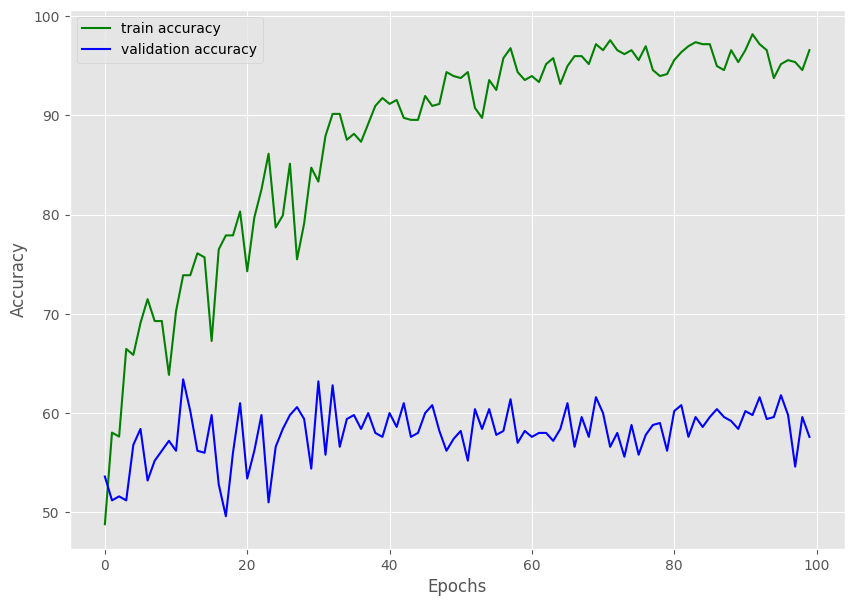

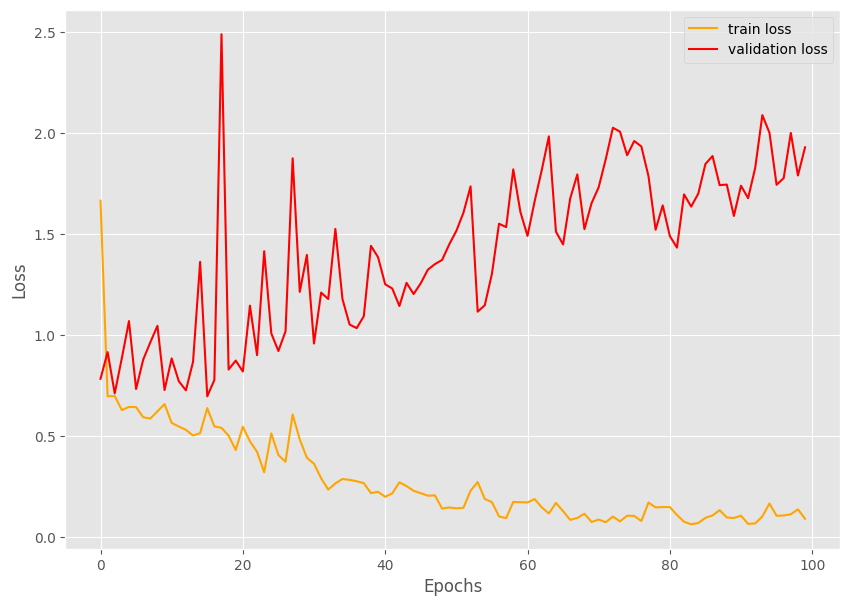

Saving model...
Training COMPLETE


In [140]:
# 모델 학습 결과 출력
print('Saving loss and accuracy plots ..')
plt.figure(figsize=(10, 7))
# 데이터셋에 대한 정확도를 그래프로 출력
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'../data/img/{acc_plot_name}.png')
plt.show()
plt.figure(figsize=(10, 7))
# 데이터셋에 대한 오차를 그래프를 출력
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'../data/img/{loss_plot_name}.png')
plt.show()

print('Saving model...')
# 모델을 저장
torch.save(model.state_dict(), f'../data/img/{model_name}.pth')
print('Training COMPLETE')